# Finding the volume dependant main channel capillary pressure of the off-valve transistor (capillary-FET) using the Z001 chip

The closing time of the off-valve transistor or capillary-FET depends on the liquid flow rate in the trigger channel. The flow rate, in turn, is defined by total capillary pressure difference between the trigger channel and the main channel, divded by the flow resistance of the trigger channel and main channel. Using this, we can express the closing time of the c-FET as.

\begin{equation}
t_{close} = \int_0^{V_p} \frac{R_l(V) + R_g(V)}{p_{cap,tr} - p_{cap,main}}
\end{equation}

Finding the capillary pressure of the trigger channel is trivial - it can be calculated using the Young-laplace equation for a square microchannel.

\begin{equation}
p_{cap} = -\gamma(\frac{cos\theta_{PDMS} + cos\theta_{PMMA}}{h} + 2\frac{cos\theta_{PMMA}}{w}) = -\gamma(R_{horizontal}^{-1} + R_{vertical}^{-1})
\end{equation}

In addition, the flow resistance of the trigger channel can be calculated from well established empirical models

\begin{equation}
R_h = \frac{12\mu L}{wh^3(1-0.63\frac{h}{w})}
\end{equation}

Finding the capillary pressure of the main channel is more complicated. The meniscus shape depends on the the volume of the bubble - so it will change throughout the closing of the capillary-FET. However, we can find this pressure by using the Z001 chip. This design uses trigger channels with precisely defined volumes to put the the occluding bubbles into a large range of stable states between fully open, and fully closed. This gives a stable snapshot of the bubble at defined points throughout the closing. A radius can then be fitted to the bubble, and the capillary pressure extracted throughout the closing of the valve.

In [1]:
# -----------------Python packages and package parameter settings -----------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import scipy.signal as sp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [2]:
# DO NOT ADJUST - relevant to the physical experiment underpinning this model

# -----------------Camera Parameters------------------------
pixel_to_mm = 1e-5 # Factor converting from pixels to metres

# this array is the real volumes of the trigger channel volumes up to the pinch off volume. 
# this is hard coded by the experiment and cannot be adjsuted in this code
trigger_channel_volumes = np.linspace(5.7,25.7,20)
pinch_off_volume = 25.7e-9 #litres 
main_chanel_depth = 200e-6 # metres

In [3]:
# ------------------------------Parameters in this cell can be adjusted to simulate the effect of different properties ------------------------------------
# Liquid and gas properties
gamma_water = 0.072 # N/m
mu_air = 1.872e-5 # Pa.S @25C from https://www.engineersedge.com/physics/viscosity_of_air_dynamic_and_kinematic_14483.html
mu_water = 8.9e-4 # Pa.s @25C same source as above

# the number of intermediate points to analyse
step_size= 100

# Trigger Channel geometries
total_channel_length = 10e-3 # metres
w_tr_channel = 100e-6 #metres
h_tr = np.linspace(20e-6,150e-6, step_size) # metres

# Solid surface properties
theta_pmma = np.linspace(0, 60, step_size)
theta_pdms = 90*np.ones(step_size)
thetas = np.array([np.deg2rad(theta_pmma), np.deg2rad(theta_pdms)])


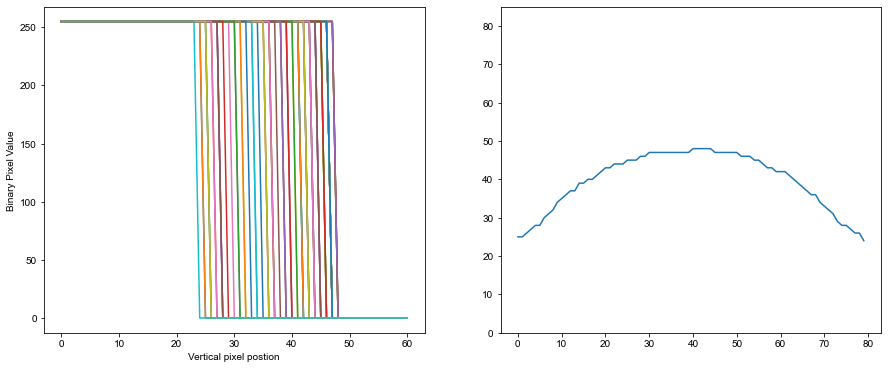

In [4]:
# Open the image, and plot vertical slices through the meniscus.
im = Image.open('test_fittingij.tif')
test = np.array(im)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.plot(test)
plt.xlabel('Vertical pixel postion')
plt.ylabel('Binary Pixel Value')


def transition_index(bin_array):
    '''
    Scans binary Image matrix columns, and saves the first transition point.
    '''
    arc = np.array([])
    # The if statement sets the intital value - transition point is when it changes from val.
    if bin_array[0,:][0] == 255:
        val = 255
    else:
        val = 0
    ## ii is the transistion point.
    for i in range(0,len(bin_array[0,:])):
        section = bin_array[:,i]
        ii = 0
        while section[ii] == val:
            ii+=1
        arc = np.append(arc, ii)
    return arc
            
    
# Plot the indetified transition point
first_arc= transition_index(test)
ax = fig.add_subplot(122)
ax.plot(first_arc)
plt.ylim((0,85))
plt.ylim((0,85))
plt.show()

# Multi-variate gradient descent

To initialise the values
1. Assume the bubble is a cicular arc ($r = y^2 - x^2$), and that the 'turning point' of the arc is horizontal|veritcal with its origin. This defines the x-coordinate of the circle origin. 
2. Start with an assumed Y origin coordinate. Calculate a radius from the distance to the turning point.

To fit the parameters

3. Take the current parameters, and some step size parameter.
4. Calculate the error gradient for every parameter, gamma*previous_gradient distance away from the present point.
5. Use that vector error gradient to update the parameters.
6. Calculate the new arc, and mean sqaure error.
7. Repeat 3-6 until some error threshold.

In [5]:
def calculate_mse(data, arc):
    '''
    Takes in the data and calcualtes the MSE between the measured data and the fitting.
    '''
    mse = ((data - arc)**2).mean()
    return mse


def calculate_new_error_gradient(params, mse, gamma, gradient, x_values, data):
    '''
    Calculates the error gradient, gamma steps away from the current arc.
    '''
    # I was going to write this in a loop, but my encoding is silly.
    # Should have used matrices and vectors.
    
    # Calculate x_gradient
    new_x = params[0] - gamma[0]*gradient[0]
    arc_x = np.sqrt(params[2]**2 - (x_values - new_x)**2) + params[1]
    mse_x = calculate_mse(data, arc_x)
    
    # If statement stops divide by zero errors
    if new_x == params[0]:
        g_mse_x = 0
    else:
        g_mse_x = (mse_x - mse)/(new_x - params[0])
    
    # Calculate y gradeint
    new_y = params[1] - gamma[1]*gradient[1]
    arc_y = np.sqrt(params[2]**2 - (x_values - params[0])**2) + new_y
    mse_y = calculate_mse(data, arc_y)
    if new_y == params[1]:
        g_mse_y = 0
    else:
        g_mse_y = (mse_y - mse)/(new_y - params[1])
        
    new_r = params[2] - gamma[2]*gradient[2]
    arc_r = np.sqrt(new_r**2 - (x_values - params[0])**2) + params[1]
    mse_r = calculate_mse(data, arc_r)
    if new_r == params[2]:
        g_mse_r = 0
    else:
        g_mse_r = (mse_r - mse)/(new_r - params[2])
    
    # put the three error gradients into a vector
    mse_gradient = [g_mse_x, g_mse_y, g_mse_r]
    
    # if a NaN has snuck in there, report it.
    if np.isnan(mse_gradient).any():
        print('NaN found')
    
    return mse_gradient
        
def update_params(params, gamma, gradient):
    '''
    Using the 3D error gradient, update the new arc parameters
    '''
    new_x = params[0] - gamma[0]*gradient[0]
    new_y = params[1] - gamma[1]*gradient[1]
    new_r = params[2] - gamma[2]*gradient[2]
    
    params = [new_x, new_y, new_r]
    
    return params

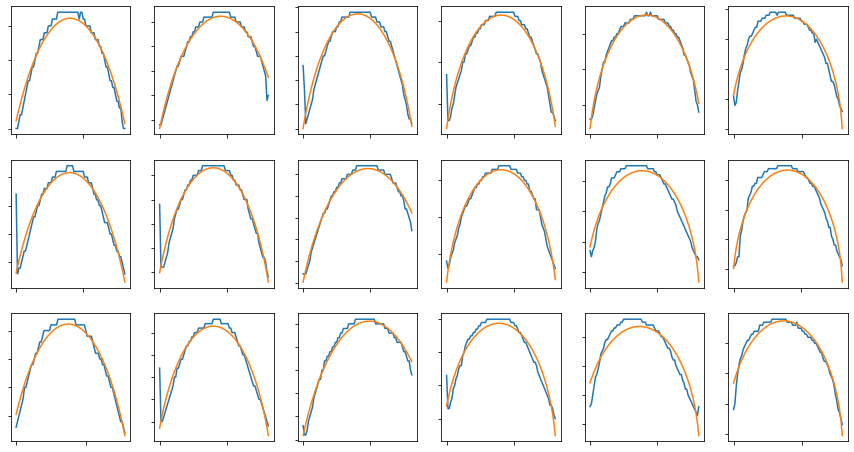

In [6]:
# all ImageJ processes images are in the folder "/meniscus-picture/"

# Open all images, and then repeat this entire process.
meni_images = []
for file_num in range(1,21):
    im = Image.open('meniscus-pictures/{}.tif'.format(file_num))
    meni_images.append(np.array(im))

# Convert all these images into data points which can be fitted.
extracted_arcs = []
for meniscus in meni_images:
    arc = transition_index(meniscus)
    extracted_arcs.append(arc)

# Arrays for storing values as they are calculated
r_params = []
global_params = []

# the same process as previous, but now looped - and with a few other checks in there

for meni in extracted_arcs:
    max_val = max(meni)
    max_index = np.where(meni == max_val)
    if (len(max_index[0]) > 1):
        centre_index = len(max_index[0])//2
        x_origin = max_index[0][centre_index]
    y_origin = min(meni) -  len(meni)
    x_values = np.linspace(0,len(meni),len(meni))

    r_arc = meni[x_origin] - y_origin
    new_arc = np.sqrt(r_arc**2 - (x_values - x_origin)**2) + y_origin
    mse = ((new_arc - meni)**2).mean()
    mse_gradient = [0.5, 0.5, 0.5]

    arc_params = [x_origin, y_origin, r_arc]
    gammas = [0.01, 0.15, 0.03]
    
    while mse > 1:
        mse_gradient = calculate_new_error_gradient(arc_params, mse, gammas, mse_gradient, x_values, meni)
        arc_params = update_params(arc_params, gammas, mse_gradient)
        new_arc = np.sqrt(arc_params[2]**2 - (x_values - arc_params[0])**2) + arc_params[1]
        mse = calculate_mse(meni, new_arc)
        # this just checks if the error gradient has completely plataued, and kills the loop
        # a bad way of doing things -  but it works for now
        if np.count_nonzero(mse_gradient) == 0:
            mse = 0
    
    r_params.append(arc_params[2])
    global_params.append(arc_params)

# plots all the fitted arcs for a manual check of the fit
ncols = 6
nrows = len(extracted_arcs)//ncols
fig,axs = plt.subplots(nrows, ncols,figsize=(15,8))
for i in range(ncols):
    for ii in range(nrows):
        data = extracted_arcs[nrows*i + ii]
        x_values = np.linspace(0,len(data),len(data))
        plotting_arc = np.sqrt(global_params[nrows*i + ii][2]**2 - (x_values - global_params[nrows*i + ii][0])**2) + global_params[nrows*i + ii][1]
        axs[ii,i].plot(data)
        axs[ii,i].plot(plotting_arc)
        axs[ii,i].set_xticklabels([])
        axs[ii,i].set_yticklabels([])

plt.show()

Next, plot the radii of all of these arcs changing over trigger channel displacement.

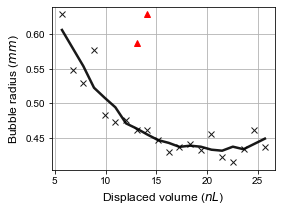

In [7]:
r_raw = r_params
r_filtered = np.copy(r_params)

# Replace the two major outliers with linear interpolatation of there neighbours
r_filtered[7] = (r_filtered[6] + r_filtered[9])/2
r_filtered[8] = (r_filtered[6] + r_filtered[9])/2

# Use a linear filter to smooth the result.
smoothed_r_params = sp.savgol_filter(r_filtered,5,1)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
ax.plot(trigger_channel_volumes[7:9],1000*pixel_to_mm*np.array(r_raw)[7:9],'r^', label='raw data')

ax.plot(trigger_channel_volumes, 1000*pixel_to_mm*np.array(r_filtered),'kx',label='outliners removed',linewidth=0,alpha=0.9,)

ax.plot(trigger_channel_volumes, 1000*pixel_to_mm*np.array(smoothed_r_params),label='outliners removed',linewidth=2.5,alpha=0.9,color='k')

plt.ylabel('Bubble radius ($mm$)',fontsize=12)
plt.xlabel('Displaced volume ($nL$)',fontsize=12)
plt.grid('both')
plt.show()



The result is a bit noisy. There are also two clear outliers. These stem from the meniscus not pinning at the geometric edges of the void volume edge, but rather off some point outside the channel. As a result, I will remove the outliers, smooth the result with a sav-gol filter, and interpolate the result at some sample rate. 

# Closing time 

We now need to use the contact angle to calculate the capillary pressure of the system.  We do not know the contact angle, because it changes substantially between runs with plasma ashing. Due to this, I'm going to calculate it for a range.

Assumed material values: $\gamma_{water} = 0.072 N/m$, and $\theta_{PDMS} = 90$.

### Process

0. Assume a constant total trigger channel length - but varied depth, and contact angle.

1. For a each trigger channel depth, calculate the channel length which means the pinch off volume of air has been displaced ($L_p = \frac{V_p}{hw}$).

2. Calculate the change of the channel resistance over that length, both gas and water contributions ($R_{tr} = \frac{12\mu_{H_2O}L_{H_2O}}{wh^3(1-0.63\frac{h}{w})} + \frac{12\mu_{air}(L - L_{H_2O})}{wh^3(1-0.63\frac{h}{w})}$).

3. Calculate and substitute in the capillary pressures.

4. Numerically integrate the resulting flow rates up until the pinch off volume, and use to find the closing time.

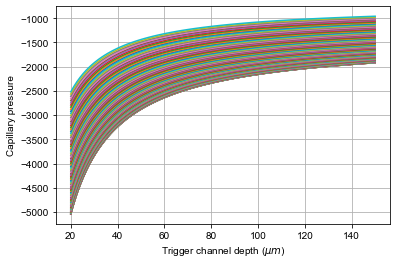

In [8]:

def trigger_channel_pcap(h, w, theta, gamma = gamma_water):
    '''
    Returns capillary pressure of rectangular channel
    
    Written in a way to accept the coloumn vectors
    '''
    return -gamma*((np.cos(theta[0,:]) + np.cos(theta[1,:]))/h + 2*np.cos(theta[0,:])/w)

def rh_square(mu, w, h, L):
    '''
    returns the hydraulic resistance of a sqaure channel while water is displaced
    
    '''
    return 12*mu*L/(w*h**3*(1-0.63*(h/w)))

def main_channel_pcap(radii, gamma= gamma_water):
    '''
    Evaluates the young-laplace equation using the principal radii form.
        
    radii[0] is the vertical component, which is a function of contact angle.
    radii[1] is horizontal component, extracted from the gradient descent above,
    '''
    return -gamma * ((1/radii[0].reshape(len(radii[0]),1)) + 1/radii[1])

h_tr_channel = h_tr.reshape((step_size,1))
p_cap_tr = trigger_channel_pcap(h_tr_channel, w_tr_channel, thetas)

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(1e6*h_tr_channel,p_cap_tr)
plt.grid('both')

plt.xlabel('Trigger channel depth ($\mu m$)')
plt.ylabel('Capillary pressure')

plt.show()

Trigger channel pressure matrix: Function of channel depth and contact angle.

Contact angle goes across the columns, trigger channel depth goes down the rows

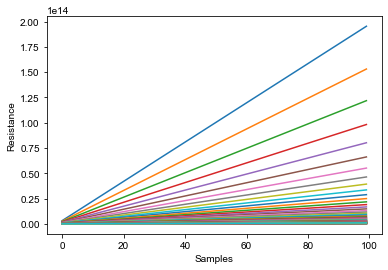

In [9]:
# Start by calculating what the length which will pinch off the channel
# divide pinch-off volume by the channel area, times by 1000 for length in mm
closing_length = []
for height in h_tr_channel:
    closing_length.append(pinch_off_volume/(1000*height*w_tr_channel))

# next turn the "final length" into an evenly spaced array of points.
lengths = []
for length in closing_length:
    lengths.append(np.linspace(0.0,length,step_size))

# use the new array of lengths to also create an matrix of all the volumes
volumes = np.array(lengths)*w_tr_channel*h_tr_channel

# Next, construct the fluid resistance matrix.
# sum of the fluid resistances as a funciton of changing length.
lengths = np.transpose(lengths)
r_specific = rh_square(mu_water,
                       w_tr_channel,
                       np.transpose(h_tr_channel),
                       lengths[0]) + rh_square(mu_air,
                                               w_tr_channel,
                                               np.transpose(h_tr_channel),
                                               (total_channel_length  - lengths[0]))

#plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(r_specific)
plt.ylabel('Resistance')
plt.xlabel('Samples')
plt.show()

Array is a product of volume and trigger channel geometry.

Volume goes down rows, and trigger channel depth is across columns.

Every point in the resistance should have a corresponding point in the main channel capillary pressure. 

To calculate the main channel capillary pressure the principal radii form of the Young-Laplace equation can be used. The horizontal radius is found from the meniscus fittings above, while the vertical radius is found by

\begin{equation}
R_{vertical} = \frac{h_{main}}{cos\theta_{PMMA} + cos\theta_{PDMS}}
\end{equation}

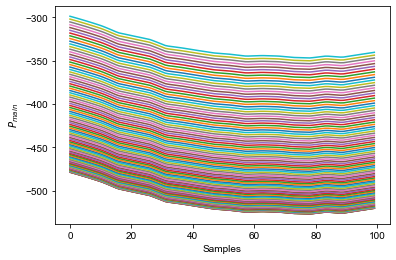

In [10]:
# calculate the main channel capillary presssure.
# interpolate the meniscus radii so that the dispalced volumes arrays have a corresponding radii
# first arg is volume points the up-sampled volume points, expressed in uL, second two arguments, are the X, Y points that are going to be linearly interpolated and upsampled.
radii_horizontal = pixel_to_mm*np.interp(1000*np.linspace(0.0057,0.0257,step_size), trigger_channel_volumes, smoothed_r_params)

# calculate the radius of the vertical component of the meniscus
radii_vertical = main_chanel_depth/(np.cos(np.deg2rad(theta_pmma)) + np.cos(np.deg2rad(90)))

principle_radii = [radii_horizontal, radii_vertical]
p_cap_main = main_channel_pcap(principle_radii)

# Plot the variation of main channel pressure against displaced volume
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(p_cap_main)
plt.xlabel('Samples')
plt.ylabel('$P_{main}$')
plt.show()

Main channel capillary pressure is a product of displaced volume and capillary pressure.
Displaced volume is going down rows, contact angle going across coloumns.

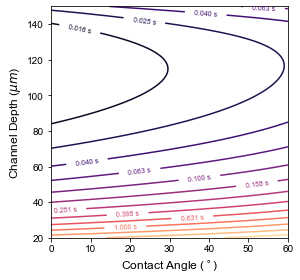

In [14]:
# Empty array to store results in
results = np.empty((0,step_size),float)

# Perform the actual integration
for i in range(step_size):
    row_result = []
    for ii in range(step_size):
        # numerical integration of the model - checks for negative flow before attempting.
        if np.any(-1.0*(p_cap_tr[i,ii] - p_cap_main[:,i]) < 0):
            integrated_result = np.nan
        else:
            integrated_result = np.trapz((r_specific[:,ii])/(-1.0*(p_cap_tr[i,ii] - p_cap_main[:,i])),
                                         x=volumes[i,:].reshape(-1))
        
        
        row_result.append(integrated_result)
    
    row_result = np.array([row_result])
    results = np.append(results, row_result,axis=0)

# generate the plot 
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

# Arrays which are used for the plotting
channels = np.empty((0, step_size))
thee = np.empty((0, step_size))


for i in range(step_size):
    channels = np.append(channels, [h_tr],axis=0)
    thee = np.append(thee, [np.flip(theta_pmma)],axis=0)

# Contour plot
CS = ax.contour(thee.transpose(), 1e6*channels, np.log10(results),15,cmap='magma')
ax.set_xlabel('Contact Angle ($^\circ$)', fontsize=12)

fmt = {}
strs = 10**(CS.levels)
for l, s in zip(CS.levels[0:-4:1], strs[0:-4:1]):
    fmt[l] = '{:.3f} s'.format(s)
    
ax.clabel(CS,CS.levels[0:-4:1],fmt=fmt,fontsize=7)

plt.tight_layout()
ax.set_ylabel('Channel Depth ($\mu m$)',fontsize=12)
plt.savefig('closing-time.png', dpi=500, bbox_inches='tight')


In [15]:
print('The minimum closing time is {} seconds'.format(np.nanmin(results)))
print('The maximum closing time is {} seconds'.format(np.nanmax(results)))

The minimum closing time is 0.010185219670789352 seconds
The maximum closing time is 5.421049963498329 seconds


In [16]:
optimal_theta = np.where(results == np.nanmin(results))[0]
optimal_channel = np.where(results == np.nanmin(results))[1]

print('The optimum closing contact angle is:', np.flip(theta_pmma)[optimal_theta], 'degrees')
print('The optimum trigger channel depth is:', h_tr[optimal_channel], 'meters')

The optimum closing contact angle is: [0.] degrees
The optimum trigger channel depth is: [0.00011586] meters
